<a href="https://colab.research.google.com/github/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_4_facial_points.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# T81-558: Applications of Deep Neural Networks
**Module 9: Transfer Learning**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 9 Material

* Part 9.1: Introduction to Keras Transfer Learning [[Video]](https://www.youtube.com/watch?v=AtoeoNwmd7w&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_1_keras_transfer.ipynb)
* Part 9.2: Keras Transfer Learning for Computer Vision [[Video]](https://www.youtube.com/watch?v=nXcz0V5SfYw&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_2_keras_xfer_cv.ipynb)
* Part 9.3: Transfer Learning for NLP with Keras [[Video]](https://www.youtube.com/watch?v=PyRsjwLHgAU&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_3_transfer_nlp.ipynb)
* **Part 9.4: Transfer Learning for Facial Feature Recognition** [[Video]](https://www.youtube.com/watch?v=uUZg33DfCls&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_4_facial_points.ipynb)
* Part 9.5: Transfer Learning for Style Transfer [[Video]](https://www.youtube.com/watch?v=pLWIaQwkJwU&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](https://github.com/jeffheaton/t81_558_deep_learning/blob/master/t81_558_class_09_5_style_transfer.ipynb)

# Google CoLab Instructions

The following code ensures that Google CoLab is running the correct version of TensorFlow.

In [1]:
try:
    %tensorflow_version 2.x
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

Note: not using Google CoLab


# Part 9.4: Transfer Learning for Facial Points and GANs

I designed this notebook to work with Google Colab. You can run it locally; however, you might need to adjust some of the installation scripts contained in this notebook.

This part will see how we can use a 3rd party neural network to detect facial features, particularly the location of an individual's eyes. By locating eyes, we can crop portraits consistently. Previously, we saw that GANs could convert a random vector into a realistic-looking portrait. We can also perform the reverse and convert an actual photograph into a numeric vector. If we convert two images into these vectors, we can produce a video that transforms between the two images. 

**NVIDIA trained StyleGAN on portraits consistently cropped with the eyes always in the same location.** To successfully convert an image to a vector, we must crop the image similarly to how NVIDIA used cropping. 

The code presented here allows you to choose a starting and ending image and use StyleGAN2 to produce a "morph" video between the two pictures. **The preprocessing code will lock in on the exact positioning of each image, so your crop does not have to be perfect. The main point of your crop is for you to remove anything else that might be confused for a face.** If multiple faces are detected, you will receive an error.

Also, make sure you have selected a GPU Runtime from CoLab. Choose "Runtime," then "Change Runtime Type," and choose GPU for "Hardware Accelerator."

These settings allow you to change the high-level configuration. The number of steps determines how long your resulting video is. The video plays at 30 frames a second, so 150 is 5 seconds. You can also specify freeze steps to leave the video unchanged at the beginning and end. You will not likely need to change the network.


In [1]:
NETWORK = "https://nvlabs-fi-cdn.nvidia.com/"\
  "stylegan2-ada-pytorch/pretrained/ffhq.pkl"
STEPS = 150
FPS = 30
FREEZE_STEPS = 30

## Upload Starting and Ending Images

We will begin by uploading a starting and ending image. The Colab service uploads these images. If you are running this code outside of Colab, these images are likely somewhere on your computer, and you provide the path to these files using the **SOURCE** and **TARGET** variables.

Choose your starting image.

In [2]:
SOURCE_NAME = './facial_points_data/jeff_heaton.jpeg'

Also, choose your ending image.

In [3]:
TARGET_NAME = './facial_points_data/Angelina-Jolie.jpg'

## Install Software

Some software must be installed into Colab, for this notebook to work. We are specifically using these technologies:

* [Training Generative Adversarial Networks with Limited Data](https://arxiv.org/abs/2006.06676)
Tero Karras, Miika Aittala, Janne Hellsten, Samuli Laine, Jaakko Lehtinen, Timo Aila
* [One-millisecond face alignment with an ensemble of regression trees](https://www.cv-foundation.org/openaccess/content_cvpr_2014/papers/Kazemi_One_Millisecond_Face_2014_CVPR_paper.pdf) Vahid Kazemi, Josephine Sullivan


In [4]:
import os
os.getcwd()

'/home/adeng/Py_workingdir/ml_learning/t81_558_deep_learning'

In [7]:
# HIDE OUTPUT
!wget http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
!bzip2 -d shape_predictor_5_face_landmarks.dat.bz2

--2023-09-17 17:39:12--  http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5706710 (5.4M)
Saving to: ‘shape_predictor_5_face_landmarks.dat.bz2’

shape_predictor_5_f 100%[===================>]   5.44M   276KB/s    in 21s     

2023-09-17 17:39:34 (260 KB/s) - ‘shape_predictor_5_face_landmarks.dat.bz2’ saved [5706710/5706710]



In [5]:
# HIDE OUTPUT
import sys
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
!pip install ninja
sys.path.insert(0, "./stylegan2-ada-pytorch")

fatal: destination path 'stylegan2-ada-pytorch' already exists and is not an empty directory.


## Detecting Facial Features

First, I will demonstrate how to detect the facial features we will use for consistent cropping and centering of the images. To accomplish this, we will use the [dlib](http://dlib.net/) package, a neural network library that gives us access to several pretrained models. The [DLIB Face Recognition ResNET Model V1](https://github.com/davisking/dlib-models) is the model we will use; This is a 5-point landmarking model which identifies the corners of the eyes and bottom of the nose. The creators of this network trained it on the dlib 5-point face landmark dataset, which consists of 7198 faces.

We begin by initializing dlib and loading the facial features neural network.

In [7]:
%pip install dlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 859.1 kB/s eta 0:00:0000:0100:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for dlib: filename=dlib-19.24.2-cp37-cp37m-linux_x86_64.whl size=4450208 sha256=86658e954c4adea1a672a4b447488ff1a4e3f5d2c4e156dff53475519c9b06fa
  Stored in directory: /home/adeng/.cache/pip/wheels/3a/98/8f/27df581c2c9da4cce02415def235adf8f71dc4eef99b122fcc
Successfully built dlib
Note: you may need to restart the kernel to use updated packages.


In [5]:
import cv2
import numpy as np
from PIL import Image
import dlib
from matplotlib import pyplot as plt

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('shape_predictor_5_face_landmarks.dat')

Let's start by looking at the facial features of the source image. The following code detects the five facial features and displays their coordinates.

In [6]:
img = cv2.imread(SOURCE_NAME)
if img is None:
    raise ValueError("Source image not found")

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
rects = detector(gray, 0)

if len(rects) == 0:
  raise ValueError("No faces detected")
elif len(rects) > 1:
  raise ValueError("Multiple faces detected")

shape = predictor(gray, rects[0])

w = img.shape[0]//50

for i in range(0, 5):
  pt1 = (shape.part(i).x, shape.part(i).y)
  pt2 = (shape.part(i).x+w, shape.part(i).y+w)
  cv2.rectangle(img,pt1,pt2,(0,255,255),4)
  print(pt1,pt2)

(316, 174) (325, 183)
(277, 175) (286, 184)
(184, 177) (193, 186)
(220, 176) (229, 185)
(250, 241) (259, 250)


We can easily plot these features onto the source image. You can see the corners of the eyes and the base of the nose.

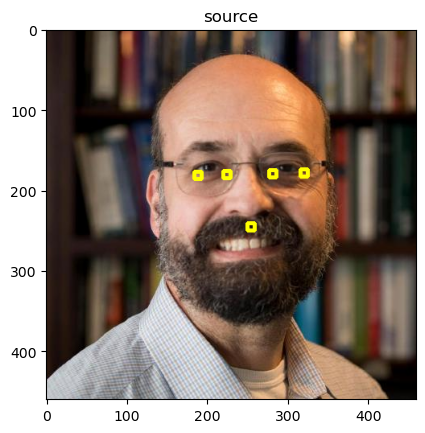

In [7]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

## Preprocess Images for Best StyleGAN Results

Using dlib, we will center and crop the source and target image, using the eye positions as reference. I created two functions to accomplish this task. The first calls dlib and find the locations of the person's eyes. The second uses the eye locations to center the image around the eyes. We do not exactly center; we are offsetting slightly to center, similar to the original StyleGAN training set. I determined this offset by detecting the eyes of a generated StyleGAN face. The distance between the eyes gives us a means of telling how big the face is, which we use to scale the images consistently.  

In [8]:
def find_eyes(img):
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  rects = detector(gray, 0)
  
  if len(rects) == 0:
    raise ValueError("No faces detected")
  elif len(rects) > 1:
    raise ValueError("Multiple faces detected")

  shape = predictor(gray, rects[0])
  features = []

  for i in range(0, 5):
    features.append((i, (shape.part(i).x, shape.part(i).y)))

  return (int(features[3][1][0] + features[2][1][0]) // 2, \
    int(features[3][1][1] + features[2][1][1]) // 2), \
    (int(features[1][1][0] + features[0][1][0]) // 2, \
    int(features[1][1][1] + features[0][1][1]) // 2)

def crop_stylegan(img):
  left_eye, right_eye = find_eyes(img)
  # Calculate the size of the face
  d = abs(right_eye[0] - left_eye[0])
  z = 255/d
  # Consider the aspect ratio
  ar = img.shape[0]/img.shape[1]
  w = img.shape[1] * z
  img2 = cv2.resize(img, (int(w), int(w*ar)))
  bordersize = 1024
  img3 = cv2.copyMakeBorder(
      img2,
      top=bordersize,
      bottom=bordersize,
      left=bordersize,
      right=bordersize,
      borderType=cv2.BORDER_REPLICATE)

  left_eye2, right_eye2 = find_eyes(img3)

  # Adjust to the offset used by StyleGAN2
  crop1 = left_eye2[0] - 385 
  crop0 = left_eye2[1] - 490
  return img3[crop0:crop0+1024,crop1:crop1+1024]

The following code will preprocess and crop your images.  If you receive an error indicating multiple faces were found, try to crop your image better or obscure the background.  If the program does not see a face, then attempt to obtain a clearer and more high-resolution image.

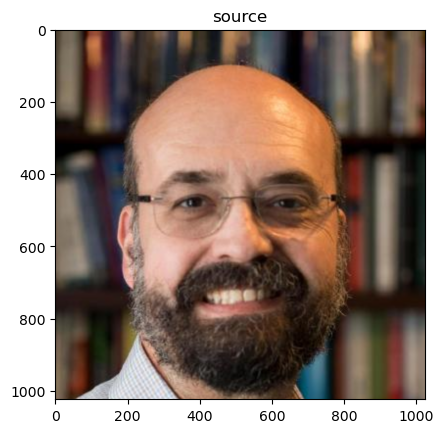

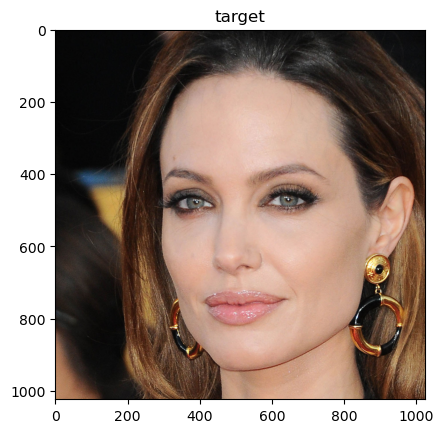

True

In [9]:
image_source = cv2.imread(SOURCE_NAME)
if image_source is None:
    raise ValueError("Source image not found")

image_target = cv2.imread(TARGET_NAME)
if image_target is None:
    raise ValueError("Source image not found")

cropped_source = crop_stylegan(image_source)
cropped_target = crop_stylegan(image_target)

img = cv2.cvtColor(cropped_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source')
plt.show()

img = cv2.cvtColor(cropped_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target')
plt.show()

cv2.imwrite("cropped_source.png", cropped_source)
cv2.imwrite("cropped_target.png", cropped_target)

#print(find_eyes(cropped_source))
#print(find_eyes(cropped_target))

The two images are now 1024x1024 and cropped similarly to the ffhq dataset that NVIDIA used to train StyleGAN.

## Convert Source to a GAN

We will use StyleGAN2, rather than the latest StyleGAN3, because StyleGAN2 contains a projector.py utility that converts images to latent vectors. StyleGAN3 does not have as good support for this [projection](https://github.com/NVlabs/stylegan3/issues/54). First, we convert the source to a GAN latent vector. This process will take several minutes.

In [16]:
%pip install imageio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.2/313.2 kB 1.3 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


#### Ancheng Comment

Failed to run below in local environment due to seemingly `ninja` command issue.

In [11]:
# HIDE OUTPUT
cmd = f"python ./stylegan2-ada-pytorch/projector.py "\
  f"--save-video 0 --num-steps 1000 --outdir=out_source "\
  f"--target=cropped_source.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Failed!
/home/adeng/Py_workingdir/ml_learning/t81_558_deep_learning/stylegan2-ada-pytorch/torch_utils/ops/bias_act.py:50: UserWarning: Failed to build CUDA kernels for bias_act. Falling back to slow reference implementation. Details:

Traceback (most recent call last):
  File "/home/adeng/miniconda3/envs/torch/lib/python3.7/site-packages/torch/utils/cpp_extension.py", line 1906, in _run_ninja_build
    env=env)
  File "/home/adeng/miniconda3/envs/torch/lib/python3.7/subprocess.py", line 512, in run
    output=stdout, stderr=stderr)
subprocess.CalledProcessError: Command '['ninja', '-v']' returned non-zero exit status 1.

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/adeng/Py_workingdir/ml_learning/t81_558_deep_lea

## Convert Target to a GAN

Next, we convert the target to a GAN latent vector.  This process will also take several minutes.

In [ ]:
# HIDE OUTPUT
cmd = f"python ./stylegan2-ada-pytorch/projector.py "\
  f"--save-video 0 --num-steps 1000 --outdir=out_target "\
  f"--target=cropped_target.png --network={NETWORK}"
!{cmd}

Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"...
Computing W midpoint and stddev using 10000 samples...
Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.
step    1/1000: dist 0.63 loss 24568.77
step    2/1000: dist 0.60 loss 27642.11
step    3/1000: dist 0.60 loss 27167.12
step    4/1000: dist 0.57 loss 26253.35
step    5/1000: dist 0.61 loss 24959.81
step    6/1000: dist 0.60 loss 23356.12
step    7/1000: dist 0.56 loss 21512.13
step    8/1000: dist 0.59 loss 19487.23
step    9/1000: dist 0.55 loss 17341.27
step   10/1000: dist 0.56 loss 15140.35
step   11/1000: dist 0.63 loss 12949.49
step   12/1000: dist 0.55 loss 10820.17
step   13/1000: dist 0.56 loss 8802.83
step   14/1000: dist 0.61 loss 6946.22
step   15/1000: dist 0.58 loss 5316.71
step   16/1000: dist 0.52 loss 3971.15
step   17/1000: dist 0.55 loss 2941.10
step   18/1000: dist 0.50 loss 2216.22
step   19/1000: dist 0

With the conversion complete, lets have a look at the two GANs.

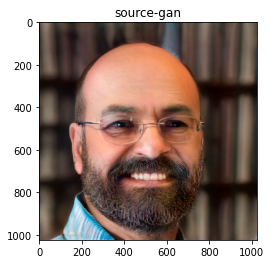

In [ ]:
img_gan_source = cv2.imread('/content/out_source/proj.png')
img = cv2.cvtColor(img_gan_source, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('source-gan')
plt.show()

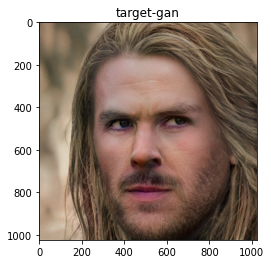

In [ ]:
img_gan_target = cv2.imread('/content/out_target/proj.png')
img = cv2.cvtColor(img_gan_target, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.title('target-gan')
plt.show()

As you can see, the two GAN-generated images look similar to their real-world counterparts. However, they are by no means exact replicas.

## Build the Video

The following code builds a transition video between the two latent vectors previously obtained.

#### Ancheng Comment

*Google Colab*: You currently have zero compute units available. R

In [ ]:
# HIDE OUTPUT
import torch
import dnnlib
import legacy
import PIL.Image
import numpy as np
import imageio
from tqdm.notebook import tqdm

lvec1 = np.load('/content/out_source/projected_w.npz')['w']
lvec2 = np.load('/content/out_target/projected_w.npz')['w']

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2"\
  "-ada-pytorch/pretrained/ffhq.pkl"
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as fp:
    G = legacy.load_network_pkl(fp)['G_ema']\
      .requires_grad_(False).to(device) 

diff = lvec2 - lvec1
step = diff / STEPS
current = lvec1.copy()
target_uint8 = np.array([1024,1024,3], dtype=np.uint8)

video = imageio.get_writer('/content/movie.mp4', mode='I', fps=FPS, 
                           codec='libx264', bitrate='16M')

for j in tqdm(range(STEPS)):
  z = torch.from_numpy(current).to(device)
  synth_image = G.synthesis(z, noise_mode='const')
  synth_image = (synth_image + 1) * (255/2)
  synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255)\
    .to(torch.uint8)[0].cpu().numpy()

  repeat = FREEZE_STEPS if j==0 or j==(STEPS-1) else 1
   
  for i in range(repeat):
    video.append_data(synth_image)
  current = current + step


video.close()

  0%|          | 0/150 [00:00<?, ?it/s]

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


## Download your Video

If you made it through all of these steps, you are now ready to download your video.

In [ ]:
# HIDE OUTPUT
from google.colab import files
files.download("movie.mp4") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>